<a href="https://colab.research.google.com/github/shomerthesec/TensorFlow-Advanced-Techniques-Specialization/blob/main/3/4/Saliency%20Maps%20demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Saliency

Like class activation maps, saliency maps also tells us what parts of the image the model is focusing on when making its predictions. 
- The main difference is in saliency maps, we are just shown the relevant pixels instead of the learned features. 
- You can generate saliency maps by getting the gradient of the loss with respect to the image pixels. 
- This means that changes in certain pixels that strongly affect the loss will be shown brightly in your saliency map. 

Let's see how this is implemented in the following sections.

## Imports

In [11]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Build the model

For the classifier, you will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) available in [Tensorflow Hub](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4). This has pre-trained weights that is able to detect 1001 classes. You can read more [here](https://tfhub.dev/google/tf2-preview/inception_v3/classification/4).

In [12]:
# grab the model from Tensorflow hub and append a softmax activation
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

# build the model based on a specified batch input shape
model.build( [None, 300, 300, 3] ) # like passing a dummy input variable to get the shapes done, without any real data passed in

## Get a sample image

You will download a photo of a Siberian Husky that our model will classify. We left the option to download a Tabby Cat image instead if you want.

In [13]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

# If you want to try the cat, uncomment this line
# !wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2021-01-03 13:33:39--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165993 (162K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 162.10K  --.-KB/s    in 0.003s  

2021-01-03 13:33:39 (50.4 MB/s) - ‘image.jpg’ saved [165993/165993]



## Preprocess the image

The image needs to be preprocessed before being fed to the model. This is done in the following steps:

In [14]:
# read the image
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize( img, (300, 300) ) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

In [15]:
image.shape

(1, 300, 300, 3)

We can now preview our input image.

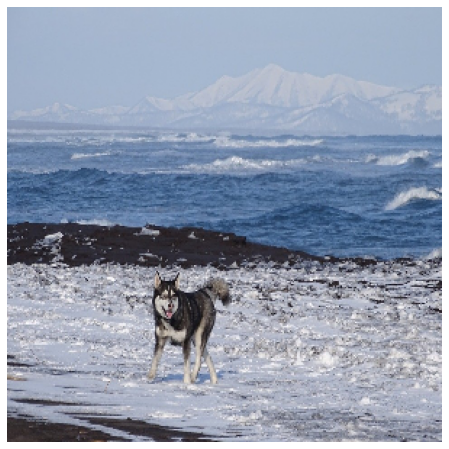

In [16]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

## Compute Gradients

You will now get the gradients of the loss with respect to the input image pixels. This is the key step to generate the map later.

In [17]:
 tf.one_hot( [2] * image.shape[0] , 10) 

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [18]:
# Siberian Husky's class ID in ImageNet
class_index = 251   

# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
# image.shape[0]=1
expected_output = tf.one_hot( [class_index] * image.shape[0] , num_classes)   # this creates a list of 1001 with 1 in the class_index and zeros elsewhere

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast( image , tf.float32 )

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy( expected_output , predictions  )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs) # of shape inputs (300x300x3)

## Visualize the results

Now that you have the gradients, you will do some postprocessing to generate the saliency maps and overlay it on the image.

In [19]:
# reduce the RGB image to grayscale
# reduce_sum over the channels, for each pixel it sums the value of the 3 channels and put them in 1 channel
grayscale_tensor = tf.reduce_sum( tf.abs(gradients) , axis=-1) # shape = ( 300x300x1 )

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.

# to denormalize the image:
# image values between [0:1]
# min value can be more than 0  so we take that and subtract it from the image [0:1] - [min value]
# max value can be less than 1 or more  too 
# for perfect ranges max=1 , min= 0 
# the denormalized image will just be 255* grayscale_tensor
# we are just taking care to not generalize the rule across all images

denormalized_tensor = tf.cast(  255  * ( grayscale_tensor - tf.reduce_min(grayscale_tensor) ) #( image - the min of the image tensor across all axies) /
                                                / ( tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor) ) # (max of the image tensor - min of the tensor)
                                                ,  tf.uint8 )

# remove the channel dimension to make the tensor a 2d tensor
denormalized_tensor = tf.squeeze( normalized_tensor ) # 300x300

Let's do a little sanity check to see the results of the conversion.

In [20]:
# max and min value of the pixels  in the grayscale tensor
print( np.max(grayscale_tensor[0]) )
print( np.min(grayscale_tensor[0]) )
print()

# coordinates of the  pixels where the max and min values are located
max_pixel_coordinates = np.unravel_index( np.argmax(grayscale_tensor[0]) , grayscale_tensor[0].shape ) # grayscale_tensor[0].shape shape of the first image
min_pixel_coordinates = np.unravel_index( np.argmin(grayscale_tensor[0]) , grayscale_tensor[0].shape )
print(max_pixel_coordinates)
print(min_pixel_coordinates)
print()

# these coordinates should have the max (255) and min (0) value in the denormalized tensor
print( denormalized_tensor[max_pixel_coordinates] ) # returns back the value of the max pixel value == 255
print( denormalized_tensor[min_pixel_coordinates] ) # returns back the value of the min pixel value == 0

1.2463936
0.0

(218, 127)
(0, 299)

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)


You should get something like:

```
1.2167013
0.0

(203, 129)
(0, 299)

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)
```

Now let's see what this looks like when plotted. The white pixels show the parts the model focused on when classifying the image.

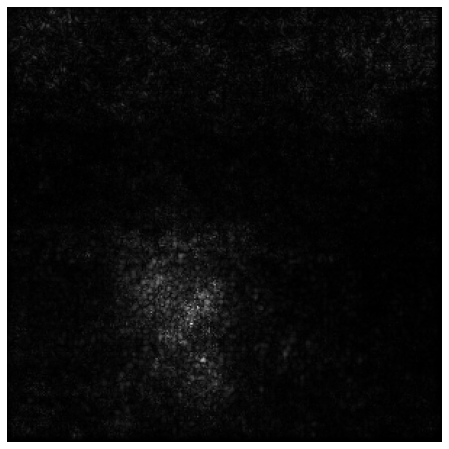

In [21]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(denormalized_tensor, cmap='gray')
plt.show()

Let's superimpose the normalized tensor to the input image to get more context. You can see that the strong pixels are over the husky and that is a good indication that the model is looking at the correct part of the image.

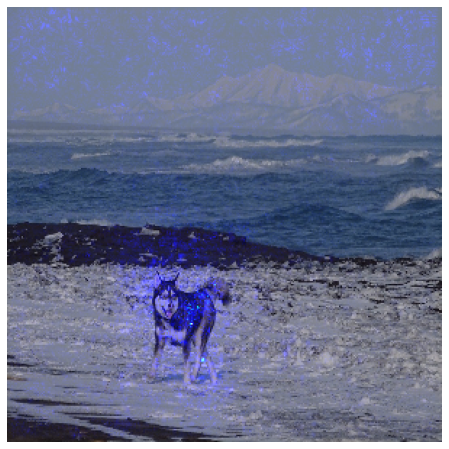

In [25]:
gradient_color = cv2.applyColorMap( denormalized_tensor.numpy() , cv2.COLORMAP_HOT )
gradient_color = gradient_color / 255.0
# adding the two images overlaying each other
super_imposed = cv2.addWeighted( img , 0.7 , gradient_color , 0.9 , 0.0 ) #  src1*alpha + src2*beta + gamma

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()